# Import Tensorflow and other libraries

In [1]:
import tensorflow as tf

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

In [2]:
dir(tf.keras)

['Input',
 'Model',
 'Sequential',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 '_sys',
 'activations',
 'applications',
 'backend',
 'callbacks',
 'constraints',
 'datasets',
 'estimator',
 'experimental',
 'initializers',
 'layers',
 'losses',
 'metrics',
 'mixed_precision',
 'models',
 'optimizers',
 'preprocessing',
 'regularizers',
 'utils',
 'wrappers']

## Tweakable Parameters

In [3]:
BUFFER_SIZE = 7000
BATCH_SIZE = 16
IMAGE_WIDTH = 512
IMAGE_HEIGHT = 512

## Load the dataset

In [4]:
dataset_dir = "/home/fdb/Source/pix2pix-tensorflow/2022-hallways/_input_border_64"

In [5]:
sample_image = tf.io.read_file(os.path.join(dataset_dir, 'hallway-0001.jpg'))
sample_image = tf.io.decode_jpeg(sample_image)
print(sample_image.shape)

(512, 1024, 3)


2022-02-01 16:54:18.351930: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-01 16:54:18.352471: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-01 16:54:18.353789: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


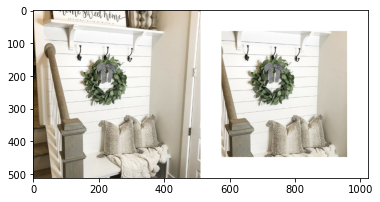

In [6]:
plt.figure()
plt.imshow(sample_image)

In [7]:
def load_image(fname):
    # Read and decode an image file to a uint8 tensor
    image = tf.io.read_file(fname)
    image = tf.io.decode_jpeg(image)
    
    # Split the image tensor into two tensors:
    # - The left (target) image
    # - The right (source) image
    image_width = tf.shape(image)[1]
    image_width = image_width // 2
    source_image = image[:, image_width:, :]
    target_image = image[:, :image_width, :]
    
    # Convert both images to float32 tensors
    source_image = tf.cast(source_image, tf.float32)
    target_image = tf.cast(target_image, tf.float32)
    
    # Normalize the images to [-1, 1]
    source_image = source_image / 255.0
    target_image = target_image / 255.0
    
    return source_image, target_image

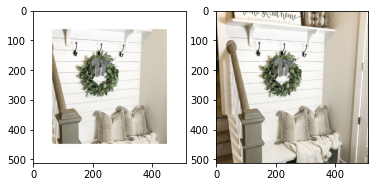

In [8]:
sample_source_image, sample_target_image = load_image(os.path.join(dataset_dir, 'hallway-0001.jpg'))
fig = plt.figure()
fig.add_subplot(1, 2, 1).imshow(sample_source_image)
fig.add_subplot(1, 2, 2).imshow(sample_target_image)
plt.show()

## Build an input pipeline with tf.data

In [9]:
train_dataset = tf.data.Dataset.list_files(os.path.join(dataset_dir, '*.jpg'))
train_dataset = train_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


## Build the generator
The generator is a modified U-Net, consisting of an enoder (downsampler) and decoder (upsampler).
The encoder consists of a number of blocks. Each block contains convolution -> batch normalization -> leaky RELU
The decoder consists of a number of blocks. Each block contains a transposed convolution -> batch normalization -> dropout (in first 3 blocks) -> ReLU
There are skip connections between the encoder and decoder.

In [10]:
def make_downsample_block(filters, size, apply_batch_norm=True):
    initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02)
    block = tf.keras.Sequential()
    block.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    if apply_batch_norm:
        block.add(tf.keras.layers.BatchNormalization())
    block.add(tf.keras.layers.LeakyReLU())
    return block


In [19]:
test_downsample_block = make_downsample_block(3, 4)
test_downsample_result = test_downsample_block(tf.expand_dims(sample_source_image, 0))
print(test_downsample_result.shape)

(1, 256, 256, 3)


In [20]:
def make_upsample_block(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02)
    block = tf.keras.Sequential()
    block.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    block.add(tf.keras.layers.BatchNormalization())
    if apply_dropout:
        block.add(tf.keras.layers.Dropout(0.5))
    block.add(tf.keras.layers.ReLU())
    return block

In [21]:
test_upsample_block = make_upsample_block(3, 4)
test_upsample_result = test_upsample_block(test_downsample_result)
print(test_upsample_result.shape)

(1, 512, 512, 3)


In [23]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[512, 512, 3])
    down_stack = [
        make_downsample_block(32,  4, apply_batch_norm=False), # (?, 256, 256,   32)
        make_downsample_block(64,  4),                         # (?, 128, 128,   64)
        make_downsample_block(128, 4),                         # (?,  64,  64,  128)
        make_downsample_block(256, 4),                         # (?,  32,  32,  256)
        make_downsample_block(512, 4),                         # (?,  16,  16,  512)
        make_downsample_block(512, 4),                         # (?,   8,   8,  512)
        make_downsample_block(512, 4),                         # (?,   4,   4,  512)
        make_downsample_block(512, 4),                         # (?,   2,   2,  512)
        make_downsample_block(512, 4),                         # (?,   1,   1,  512)
    ]
    
    up_stack = [
        make_upsample_block(512, 4, apply_dropout=True),       # (?,   2,   2, 1024)
        make_upsample_block(512, 4, apply_dropout=True),       # (?,   4,   4, 1024)
        make_upsample_block(512, 4, apply_dropout=True),       # (?,   8,   8, 1024)
        make_upsample_block(512, 4),                           # (?,  16,  16, 1024)
        make_upsample_block(256, 4),                           # (?,  32,  32,  512)
        make_upsample_block(128, 4),                           # (?,  64,  64,  256)
        make_upsample_block( 64, 4),                           # (?, 128, 128,  128)
        make_upsample_block( 32, 4),                           # (?, 256, 256,   64)
    ]    

    initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02)
    # (?, 512, 512, 3)
    last = tf.keras.layers.Conv2DTranspose(3, 4, strides=2, padding='same', kernel_initializer=initializer, activation='tanh')
    
    x = inputs
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
        
    skips = reversed(skips[:-1])
    
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])
    
    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [26]:
generator = Generator()
# FIXME: his currently fails because we don't have pydot
#tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

## Test the generator

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


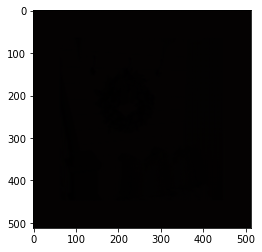

In [44]:
gen_output = generator(tf.expand_dims(sample_source_image, 0), training=False)
plt.imshow(gen_output[0, ...])

(1, 512, 512, 3)
